# Use FB Prophet for Multivariate Time-series Forecasting: Six Group merchant for sum of 74 transactions

Prophet is an open source library developed by Facebook which aims to make time-series forecasting easy and scalable. It is a type of a generalized additive model (GAM), which uses regression model with potentially non-linear smoothers. It is called additive because it addes multiple decomposed parts to explain some trends. For example, Prophet uses the following components: 

$$ y(t) = g(t) + s(t) + h(t) + e(t) $$

where,  
$g(t)$: Growth. Big trend. Non-periodic changes.   
$s(t)$: Sesonality. Periodic changes (e.g. weekly, yearly, etc.) represented by Fourier Series.  
$h(t)$: Holiday effect that represents irregular schedules.   
$e(t)$: Error. Any idiosyncratic changes not explained by the model. 

# Table of Contents 
1. [Prepare Data](#prep)
2. [Get Data](#data)
3. [Data Processing](#processing)
4. [Train Test Split](#split)
5. [Baseline Model](#baseline)
6. [Multivariate Model](#multivariate)
7. [References](#References)

# Step 1: Install and Import Libraries

<a id=prep></a>
# 1. Prepare Data

The goal of the time series model is to predict the six group merchant transactions. Prophet requires at least two columns as inputs: a ds column and a y column.

 * The ds column has the time information. Currently we have the date as the index, so we name this index as ds.
 * The y column has the time series transaction values. In this example, because we are predicting six group merchant transactions, the column name for the transactions is named y.

In [1]:
# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
#from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 2: Get Data

In [2]:
data_path_sum = "../../../data/raw/ninety_sum.csv"
df_merchant_transactions_sum = pd.read_csv(data_path_sum)

# Step 3: Data Processing

Step 3 transforms the dataset into a time series modeling dataset. 


Prophet requires at least two columns as inputs: a `ds` column and a `y` column.
* The `ds` column has the time information. Currently we have the date as the index, so we reset the index and rename `date` to `ds`.
* The y column has the time series values. the column name `Merchant 1` is changed to `y`.
* There is no pre-defined name for the additional predictor in prophet, so we can keep the names as is.

In [3]:
data = pd.DataFrame(df_merchant_transactions_sum.values)
# Change variable names
my_input = ['ds', 'y'] 
data.columns = my_input

# Take a look at the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      26 non-null     object
 1   y       26 non-null     object
dtypes: object(2)
memory usage: 544.0+ bytes


# Step 4: Train Test Split

In step 4, we will do the train test split. For time series data, usually a threshold date is chosen, then we set the dates before the threshold to be the training dataset and the dates after the threshold to be the testing dataset.

Based on the threshold date (`train_end_date`) we set before, there are data points in the training dataset and data points in the testing dataset.

In [4]:
# Train test split
start_date = '2020-08-31'
end_date = '2022-09-30'
train_end_date = '2022-04-30'
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(21, 2)
(5, 2)


Checking the minimum and maximum values for the train and test dataset separately gave us the starting and ending dates.

In [5]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2020-08-31
The end time of the training dataset is  2022-04-30
The start time of the testing dataset is  2022-05-31
The end time of the testing dataset is  2022-09-30


In [6]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month
period_months = diff_month(pd.to_datetime(end_date), pd.to_datetime(train_end_date))
period_months  

5

# Step 5: Baseline Model

In step 5, we will build a univariate baseline model using the default prophet hyperparameters, and fit the model using the training dataset.

## Step 5.1: Build Baseline Model

In [7]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet(interval_width=0.99, seasonality_mode='multiplicative')

# Fit the model on the training dataset
model_baseline.fit(train)

11:00:23 - cmdstanpy - INFO - Chain [1] start processing
11:00:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

The model information shows that the yearly seasonality and the daily seasonality are disabled. 
* The daily seasonality is disabled because we do not have sub-daily time series. 
* The yearly seasonality is disabled although we have two years of data. 

We will continue with the default values for the baseline model and force the yearly seasonality in the next model to see the impact of the yearly seasonality.

## Step 5.2: Baseline Model Forecast

After making the prediction on the future dataframe, we can plot the result using `.plot`.
* The black dots are the actual values.
* The blue line is the prediction.
* The blue shades are the uncertainty interval. The default value for the uncertainty interval is 80%, so we are using 80% here. The uncertainty interval is calculated based on the assumption that the average frequency and magnitude of trend changes in the future will be the same as the historical data. The historical data trend changes are projected forward to get the uncertainty intervals [1].

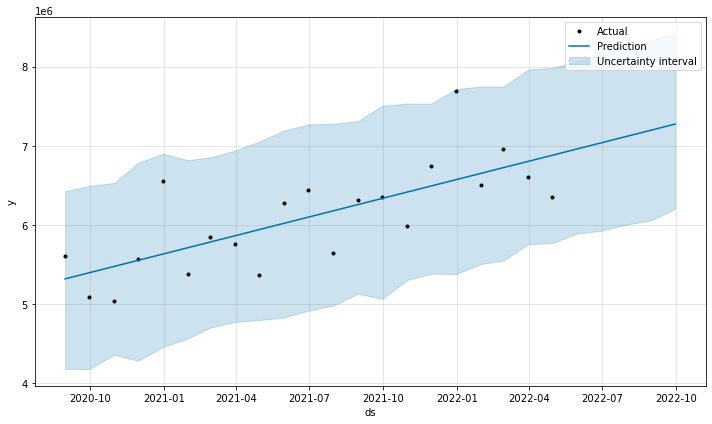

In [8]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(period_months, freq='M')

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
fig = model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

In addition to the forecast plot, prophet also provides the components plot. 

From the component plot chart, we can see that the Google stock closing price has an overall upward trend. The weekly seasonality shows that the price tends to be lower at the beginning of the week and higher at the end of the week.

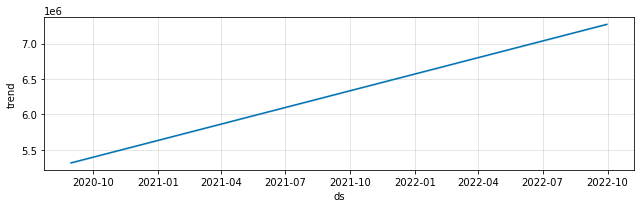

In [9]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

## Step 6: Multivariate Model Performance

In [10]:
# import the math module
import math
import sklearn.metrics

def rmse(data, forecast):
    # rmse = sqrt(sklearn.metrics.mean_squared_error(test[merchant_name].values, fitted.values))
    return math.sqrt(sklearn.metrics.mean_squared_error(data, forecast))

rmse(data['y'].iloc[21:26], forecast_baseline['yhat'][21:26])

607940.8284937565

11:00:24 - cmdstanpy - INFO - Chain [1] start processing
11:00:24 - cmdstanpy - INFO - Chain [1] done processing


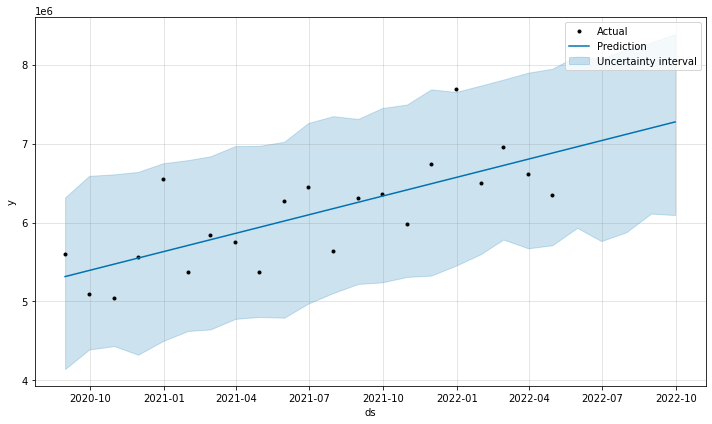

RMSE error  607940.8284937565


In [11]:
#with open('rmse_error.txt', 'w') as f:
model_univariate = Prophet(interval_width=0.99, seasonality_mode='multiplicative')
# Fit the model on the training dataset
model_univariate.fit(train)
future_multivariate = model_univariate.make_future_dataframe(period_months, freq='M')
# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
# Make prediction
forecast_multivariate = model_univariate.predict(future_multivariate)
# Visualize the forecast
fig = model_univariate.plot(forecast_multivariate)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()
error_rmse = rmse(data['y'].iloc[21:26], forecast_multivariate['yhat'].iloc[21:26])
print('RMSE error ', error_rmse);
#f.write('for merchant sum the rmse error is ')
#f.write(str(error_rmse))
#f.write('\n')

In [12]:
#forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
with open('74merchants_12months.txt', 'w') as f:
    #f.write('RMSE error ')
    #f.write(str(error_rmse))
    f.write('\n')
    f.write(str(forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]))

In [13]:
forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-31,5.315207e+06,4.144010e+06,6.317164e+06
1,2020-09-30,5.392515e+06,4.391392e+06,6.590526e+06
2,2020-10-31,5.472401e+06,4.435152e+06,6.609868e+06
3,2020-11-30,5.549709e+06,4.325570e+06,6.641105e+06
4,2020-12-31,5.629595e+06,4.498888e+06,6.750311e+06
5,2021-01-31,5.709481e+06,4.625937e+06,6.789874e+06
6,2021-02-28,5.781635e+06,4.645667e+06,6.838455e+06
7,2021-03-31,5.861521e+06,4.779303e+06,6.967639e+06
8,2021-04-30,5.938830e+06,4.803735e+06,6.970715e+06
9,2021-05-31,6.018715e+06,4.794366e+06,7.022207e+06


# References

[1] [Prophet Documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)